# import

In [18]:
import warnings
warnings.simplefilter('ignore')

import os
import gc 
import sys
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb 

from tqdm import tqdm
from collections import defaultdict
from scipy.spatial import distance
from multiprocessing import cpu_count

from sklearn.model_selection import StratifiedKFold, KFold 
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [35]:
pd.options.display.max_columns = None

NFOLDS = 5
SEED = 2019

# read

In [19]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [20]:
test.insert(1, 'target', 0)

In [21]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [22]:
test.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,0,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,0,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,0,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,0,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [23]:
train_index = train.index
test_index = test.index

# MinMaxScaler

In [24]:
var_columns = [f'var_{i}' for i in range(0, 200)]

In [25]:
df = pd.concat([train, test], axis=0)

In [26]:
scaler = MinMaxScaler()
scaler.fit(df[var_columns])
df[var_columns] = scaler.transform(df[var_columns])

In [27]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,0.394711,0.324824,0.568059,0.388041,0.550670,0.467301,0.465762,0.578688,...,0.537807,0.342943,0.568958,0.448173,0.510471,0.291973,0.678981,0.412164,0.320222,0.564556
1,train_1,0,0.511048,0.428639,0.681235,0.410417,0.628408,0.795039,0.546339,0.487471,...,0.630884,0.536531,0.523717,0.756190,0.349865,0.743892,0.686614,0.447856,0.595713,0.609337
2,train_2,0,0.380425,0.483777,0.578061,0.599690,0.474941,0.471310,0.758477,0.403860,...,0.493407,0.643141,0.448960,0.448000,0.670521,0.856859,0.236337,0.365293,0.416170,0.586451
3,train_3,0,0.491161,0.507140,0.396562,0.546993,0.647586,0.616796,0.581965,0.417350,...,0.538713,0.383085,0.370986,0.439205,0.744819,0.406918,0.346810,0.685901,0.576626,0.448188
4,train_4,0,0.435886,0.533434,0.624133,0.504796,0.621079,0.702806,0.597644,0.605921,...,0.365804,0.629275,0.299888,0.697737,0.238566,0.382291,0.557507,0.560948,0.577995,0.450972


# prepare dataset

In [31]:
train = df.iloc[train_index]
test = df.iloc[test_index]

y = train['target']

not_use_cols = ['ID_code', 'target'] 
use_cols = [c for c in train.columns if c not in not_use_cols]

In [32]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,0.394711,0.324824,0.568059,0.388041,0.550670,0.467301,0.465762,0.578688,...,0.537807,0.342943,0.568958,0.448173,0.510471,0.291973,0.678981,0.412164,0.320222,0.564556
1,train_1,0,0.511048,0.428639,0.681235,0.410417,0.628408,0.795039,0.546339,0.487471,...,0.630884,0.536531,0.523717,0.756190,0.349865,0.743892,0.686614,0.447856,0.595713,0.609337
2,train_2,0,0.380425,0.483777,0.578061,0.599690,0.474941,0.471310,0.758477,0.403860,...,0.493407,0.643141,0.448960,0.448000,0.670521,0.856859,0.236337,0.365293,0.416170,0.586451
3,train_3,0,0.491161,0.507140,0.396562,0.546993,0.647586,0.616796,0.581965,0.417350,...,0.538713,0.383085,0.370986,0.439205,0.744819,0.406918,0.346810,0.685901,0.576626,0.448188
4,train_4,0,0.435886,0.533434,0.624133,0.504796,0.621079,0.702806,0.597644,0.605921,...,0.365804,0.629275,0.299888,0.697737,0.238566,0.382291,0.557507,0.560948,0.577995,0.450972


In [33]:
test.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,0.394711,0.324824,0.568059,0.388041,0.550670,0.467301,0.465762,0.578688,...,0.537807,0.342943,0.568958,0.448173,0.510471,0.291973,0.678981,0.412164,0.320222,0.564556
1,train_1,0,0.511048,0.428639,0.681235,0.410417,0.628408,0.795039,0.546339,0.487471,...,0.630884,0.536531,0.523717,0.756190,0.349865,0.743892,0.686614,0.447856,0.595713,0.609337
2,train_2,0,0.380425,0.483777,0.578061,0.599690,0.474941,0.471310,0.758477,0.403860,...,0.493407,0.643141,0.448960,0.448000,0.670521,0.856859,0.236337,0.365293,0.416170,0.586451
3,train_3,0,0.491161,0.507140,0.396562,0.546993,0.647586,0.616796,0.581965,0.417350,...,0.538713,0.383085,0.370986,0.439205,0.744819,0.406918,0.346810,0.685901,0.576626,0.448188
4,train_4,0,0.435886,0.533434,0.624133,0.504796,0.621079,0.702806,0.597644,0.605921,...,0.365804,0.629275,0.299888,0.697737,0.238566,0.382291,0.557507,0.560948,0.577995,0.450972


In [37]:
X = train[use_cols]
X_test = test[use_cols]

# pseudo labeling

In [113]:
def cv_lightgbm(X, y, X_test, NFOLDS=5, SEED=6):
    params_in_train = {
        'num_boost_round': 20000,
        'early_stopping_rounds': 200,
        'verbose_eval': 500,
    }

    skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

    oof = np.zeros(len(X))
    predictions = np.zeros(len(X_test))
    scores = {'train': [], 'valid': []}
    features = X.columns
    feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])

    for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
        print('fold: {}/{}'.format(fold+1, skf.n_splits))
        
        params = {
            'boosting': 'gbdt',
            'metric': 'auc',
            'objective': 'binary',
            'max_depth': 6,
            'num_leaves': 12,
            'min_data_in_leaf': 64,
            'bagging_freq': 5,
            'learning_rate': 0.01,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.4,
            'reg_alpha': 2,
            'reg_lambda': 5,
            'min_gain_to_split': 0.01,
            'min_child_weight': 19,
            'num_threads': cpu_count(),
            'verbose': -1,
            'seed': int(2**fold),
            'bagging_seed': int(2**fold),
            'drop_seed': int(2**fold),
        }
        
        dtrain = lgb.Dataset(X.iloc[train_index], label=y.iloc[train_index])
        dvalid = lgb.Dataset(X.iloc[valid_index], label=y.iloc[valid_index])
        
        model = lgb.train(params, dtrain, valid_sets=[dtrain, dvalid], **params_in_train)
        scores['train'].append(model.best_score['training']['auc'])
        scores['valid'].append(model.best_score['valid_1']['auc'])
        oof[valid_index] = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)

        fold_feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])
        fold_feature_importance_df['feature'] = features
        fold_feature_importance_df['importance'] = model.feature_importance()
        fold_feature_importance_df['fold'] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_feature_importance_df], axis=0)

        predictions += model.predict(X_test, num_iteration=model.best_iteration) / NFOLDS

        del model

    return oof, predictions, scores, feature_importance_df

In [114]:
oof, predictions, scores, feature_importance_df = cv_lightgbm(X, y, X_test) 

fold: 1/5
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.856901	valid_1's auc: 0.83986
[1000]	training's auc: 0.888501	valid_1's auc: 0.868334
[1500]	training's auc: 0.903668	valid_1's auc: 0.881191
[2000]	training's auc: 0.91335	valid_1's auc: 0.888647
[2500]	training's auc: 0.919919	valid_1's auc: 0.893129
[3000]	training's auc: 0.92477	valid_1's auc: 0.896052
[3500]	training's auc: 0.928459	valid_1's auc: 0.898048
[4000]	training's auc: 0.931538	valid_1's auc: 0.899456
[4500]	training's auc: 0.934214	valid_1's auc: 0.900293
[5000]	training's auc: 0.936633	valid_1's auc: 0.900942
[5500]	training's auc: 0.939036	valid_1's auc: 0.901316
[6000]	training's auc: 0.941323	valid_1's auc: 0.901578
Early stopping, best iteration is:
[5915]	training's auc: 0.940933	valid_1's auc: 0.901616
fold: 2/5
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.857364	valid_1's auc: 0.839918
[1000]	training's auc: 0.888712	valid_1'

In [115]:
cv_score = roc_auc_score(y, oof)**0.5
print('Num folds: {}'.format(NFOLDS))
print('Train Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores['train']), np.max(scores['train']), np.min(scores['train']), np.std(scores['train'])))
print('Valid Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores['valid']), np.max(scores['valid']), np.min(scores['valid']), np.std(scores['valid'])))
print('CV Score: {:<8.5f}'.format(cv_score))

Num folds: 5
Train Scores: mean 0.94177, max 0.94341, min 0.93940, std 0.00148
Valid Scores: mean 0.89827, max 0.90162, min 0.89579, std 0.00197
CV Score: 0.94776 


In [116]:
y_test = np.array([np.where(x >= 0.5, 1, 0) for x in predictions])

In [ ]:
# y_test = np.array(predictions)

In [ ]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
def cv_pseudo_labeling_lightgbm(X, y, X_test, y_test, NFOLDS=5, SEED=6):
    params_in_train = {
        'num_boost_round': 20000,
        'early_stopping_rounds': 200,
        'verbose_eval': 500,
    }

    skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

    oof = np.zeros(len(X))
    predictions = np.zeros(len(X_test))
    scores = {'train': [], 'valid': []}
    features = X.columns
    feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])

    for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
        print('fold: {}/{}'.format(fold+1, skf.n_splits))
        
        params = {
            'boosting': 'gbdt',
            'metric': 'binary',
            'objective': 'binary',
            'max_depth': 6,
            'num_leaves': 12,
            'min_data_in_leaf': 64,
            'bagging_freq': 5,
            'learning_rate': 0.01,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.4,
            'reg_alpha': 2,
            'reg_lambda': 5,
            'min_gain_to_split': 0.01,
            'min_child_weight': 19,
            'num_threads': cpu_count(),
            'verbose': -1,
            'seed': int(2**fold),
            'bagging_seed': int(2**fold),
            'drop_seed': int(2**fold),
        }
        
        X_train = pd.concat([X.iloc[train_index], X_test], axis=0)
        y_train = np.concatenate([y.iloc[train_index], y_test], axis=0)
        
        dtrain = lgb.Dataset(X_train, label=y_train)
        dvalid = lgb.Dataset(X.iloc[valid_index], label=y.iloc[valid_index])
        
        model = lgb.train(params, dtrain, valid_sets=[dtrain, dvalid], **params_in_train)
        scores['train'].append(model.best_score['training']['binary_logloss'])
        scores['valid'].append(model.best_score['valid_1']['binary_logloss'])
        oof[valid_index] = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)

        fold_feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])
        fold_feature_importance_df['feature'] = features
        fold_feature_importance_df['importance'] = model.feature_importance()
        fold_feature_importance_df['fold'] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_feature_importance_df], axis=0)

        predictions += model.predict(X_test, num_iteration=model.best_iteration) / NFOLDS

        del model

    return oof, predictions, scores, feature_importance_df

In [ ]:
oof, psudeo_predictions, scores, feature_importance_df = cv_pseudo_labeling_lightgbm(X, y, X_test, y_test) 

fold: 1/5
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.199069	valid_1's binary_logloss: 0.270463
[1000]	training's binary_logloss: 0.173971	valid_1's binary_logloss: 0.247183
[1500]	training's binary_logloss: 0.158493	valid_1's binary_logloss: 0.233828
[2000]	training's binary_logloss: 0.147708	valid_1's binary_logloss: 0.225103
[2500]	training's binary_logloss: 0.139754	valid_1's binary_logloss: 0.219424
[3000]	training's binary_logloss: 0.133534	valid_1's binary_logloss: 0.21537
[3500]	training's binary_logloss: 0.128591	valid_1's binary_logloss: 0.212306
[4000]	training's binary_logloss: 0.124544	valid_1's binary_logloss: 0.21018
[4500]	training's binary_logloss: 0.121198	valid_1's binary_logloss: 0.208649
[5000]	training's binary_logloss: 0.118387	valid_1's binary_logloss: 0.207864
[5500]	training's binary_logloss: 0.115987	valid_1's binary_logloss: 0.207236
[6000]	training's binary_logloss: 0.113918	valid_1's binary_logloss: 0.2

In [ ]:
cv_score = roc_auc_score(y, oof)**0.5
print('Num folds: {}'.format(NFOLDS))
print('Train Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores['train']), np.max(scores['train']), np.min(scores['train']), np.std(scores['train'])))
print('Valid Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores['valid']), np.max(scores['valid']), np.min(scores['valid']), np.std(scores['valid'])))
print('CV Score: {:<8.5f}'.format(cv_score))

In [ ]:
submission = pd.read_csv(os.path.join('..', 'data', 'sample_submission.csv'))
submission['target'] = predictions
submission.to_csv(os.path.join('..', 'submission', '{}_lightgbm.csv'.format(str(datetime.datetime.today().date()).replace('-', ''))), index=False)

In [ ]:
feature_importance_df['importance'] = feature_importance_df['importance'].astype('int')
ordered_feature = feature_importance_df.groupby(['feature'])['importance'].mean().sort_values(ascending=False).index
plt.figure(figsize=(12, 48))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
sns.barplot(x='importance', y='feature', data=feature_importance_df, order=ordered_feature)
plt.show()

In [ ]:
sns.distplot(submission['target'])
plt.show()

In [ ]:
submission = pd.read_csv(os.path.join('..', 'submission', '20190317_lightgbm.csv'))

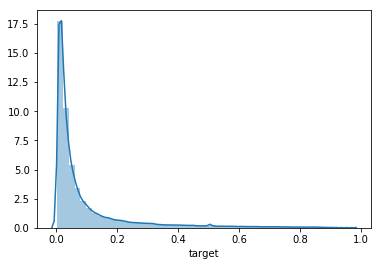

In [78]:
sns.distplot(submission['target'])
plt.show()